In [3]:
import sys, os
import numpy as np
import time, h5py
codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import default_paths, nsd_utils, coco_utils
from model_fitting import initialize_fitting 
import argparse
import pandas as pd
import matplotlib

Initializing coco api...
loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
loading annotations into memory...
Done (t=16.32s)
creating index...
index created!
Initializing coco api...
loading annotations into memory...
Done (t=0.55s)
creating index...
index created!
loading annotations into memory...
Done (t=16.51s)
creating index...
index created!


In [2]:
coco_utils.write_indoor_outdoor_csv(subject=1)

things labels assumed to be indoor:
['couch' 'potted plant' 'bed' 'dining table' 'toilet' 'tv' 'mouse'
 'remote' 'keyboard' 'microwave' 'oven' 'toaster' 'sink' 'refrigerator'
 'clock' 'vase' 'hair drier' 'toothbrush']
things labels assumed to be outdoor:
['car' 'motorcycle' 'airplane' 'bus' 'train' 'truck' 'boat'
 'traffic light' 'fire hydrant' 'stop sign' 'parking meter' 'bench'
 'horse' 'sheep' 'cow' 'elephant' 'bear' 'zebra' 'giraffe' 'frisbee'
 'skis' 'snowboard' 'sports ball' 'kite' 'baseball bat' 'baseball glove'
 'skateboard' 'surfboard' 'tennis racket']
things labels that are ambiguous:
['person' 'bicycle' 'bird' 'cat' 'dog' 'backpack' 'umbrella' 'handbag'
 'tie' 'suitcase' 'bottle' 'wine glass' 'cup' 'fork' 'knife' 'spoon'
 'bowl' 'banana' 'apple' 'sandwich' 'orange' 'broccoli' 'carrot' 'hot dog'
 'pizza' 'donut' 'cake' 'chair' 'laptop' 'cell phone' 'book' 'scissors'
 'teddy bear']
stuff labels assumed to be indoor:
['cabinet' 'carpet' 'ceiling-other' 'ceiling-tile' 'counter' 

In [4]:
subject=1
which_prf_grid=5;
prf_model_index=600;


number of pRFs: 1456
most extreme RF positions:
[2.7755576e-17 0.0000000e+00 2.0000000e-02]
[ 0.7698996  -0.31890285  1.        ]


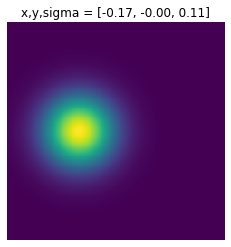

In [5]:
import matplotlib.pyplot as plt
from utils import prf_utils
which_prf_grid=5
models = initialize_fitting.get_prf_models(which_grid=which_prf_grid)
n_prfs = len(models)
mm = prf_model_index

x,y,sigma = models[mm,:]
n_pix = 240
prf_2d = prf_utils.gauss_2d(center=[x,y], sd=sigma, patch_size=n_pix)

plt.figure();
plt.pcolormesh(prf_2d)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()
plt.title('x,y,sigma = [%.2f, %.2f, %.2f]'%(x,y,sigma));

In [8]:
ims2load = np.arange(0,100)
image_data = nsd_utils.get_image_data(subject)
image_data = nsd_utils.image_uncolorize_fn(image_data[ims2load,:,:,:])
# image_data = image_data[ims2use,:,:,:]
n_images = image_data.shape[0]


Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255


In [69]:
labels_folder = os.path.join(default_paths.stim_labels_root, 'S%d_within_prf_grid%d'%(subject, \
                                                                                        which_prf_grid))


fn2load = os.path.join(labels_folder, 'S%d_cocolabs_binary_prf%d.csv'%(subject, prf_model_index))
coco_df = pd.read_csv(fn2load, index_col=0)
cat_labels = np.array(coco_df)[:,12:92]
supcat_labels = np.array(coco_df)[:,0:12]

fn2load = os.path.join(labels_folder, 'S%d_cocolabs_stuff_binary_prf%d.csv'%(subject, prf_model_index))
coco_stuff_df = pd.read_csv(fn2load, index_col=0)
stuff_cat_labels = np.array(coco_stuff_df)[:,16:108]
supcat_stuff_labels = np.array(coco_stuff_df)[:,0:16]

fn2load = os.path.join(default_paths.stim_labels_root, \
                                          'S%d_indoor_outdoor.csv'%subject)
indoor_outdoor_df = pd.read_csv(fn2load, index_col=0)
has_indoor = np.array(indoor_outdoor_df['has_indoor'])
has_outdoor = np.array(indoor_outdoor_df['has_outdoor'])
indoor_outdoor = np.concatenate([has_indoor[:,np.newaxis], \
                                 has_outdoor[:,np.newaxis]], axis=1)

In [68]:
cat_objects, cat_names, cat_ids, supcat_names, ids_each_supcat = \
                coco_utils.get_coco_cat_info(coco_utils.coco_val)

stuff_cat_objects, stuff_cat_names, stuff_cat_ids, stuff_supcat_names, stuff_ids_each_supcat = \
        coco_utils.get_coco_cat_info(coco_utils.coco_stuff_val) 


In [71]:
print(np.sum(has_outdoor & has_indoor))
print(np.sum(~has_outdoor & has_indoor))
print(np.sum(has_outdoor & ~has_indoor))
print(np.sum(~has_outdoor & ~has_indoor))

169
3007
6208
616


In [72]:
ims2load = np.arange(100)


image 0 has:
['banana', 'apple']
['metal', 'other']

image 1 has:
['cup', 'apple', 'dining table']
['fruit', 'plastic', 'table', 'other']

image 2 has:
['person', 'oven']
['cardboard', 'metal', 'other']

image 3 has:
['person', 'oven']
['cardboard', 'metal', 'other']


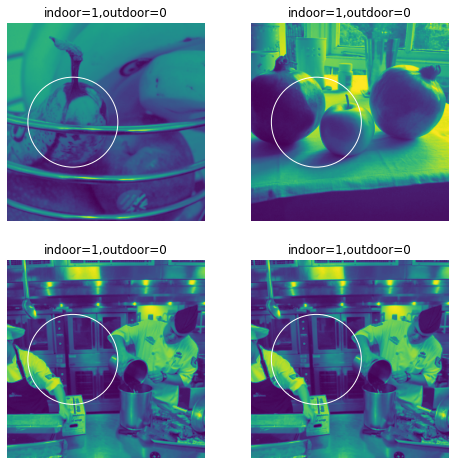

In [77]:
# plot examples - "indoor only" patches

ims2use = np.where((indoor_outdoor[:,0]==1) & (indoor_outdoor[:,1]==0) & \
                   np.isin(np.arange(10000), ims2load))[0]

images2plot = np.random.choice(ims2use,4);

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(8,8));

for ii, im in enumerate(images2plot):
    ax = plt.subplot(2,2,ii+1);
    plt.imshow(image_data[im,0,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('indoor=%d,outdoor=%d'%(indoor_outdoor[im,0], indoor_outdoor[im,1]))
    print('\nimage %d has:'%ii)
    print([cat_names[cc] for cc in range(len(cat_names)) if cat_labels[im,cc]==1])
    print([stuff_cat_names[cc] for cc in range(len(stuff_cat_names)) if stuff_cat_labels[im,cc]==1])


image 0 has:
['person', 'kite']
['grass', 'mountain', 'sky-other', 'other']

image 1 has:
['person', 'tennis racket']
['fence', 'tree', 'other']

image 2 has:
['giraffe']
['grass', 'sky-other', 'tree', 'other']

image 3 has:
[]
['banner', 'net', 'playingfield', 'wall-other']


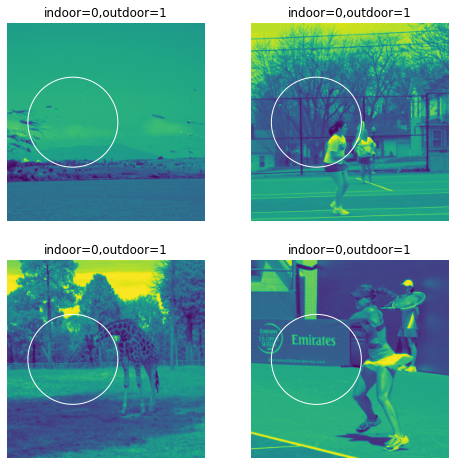

In [78]:
# plot examples - "outdoor only" patches

ims2use = np.where((indoor_outdoor[:,0]==0) & (indoor_outdoor[:,1]==1) & \
                   np.isin(np.arange(10000), ims2load))[0]
images2plot = np.random.choice(ims2use,4);

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(8,8));

for ii, im in enumerate(images2plot):
    ax = plt.subplot(2,2,ii+1);
    plt.imshow(image_data[im,0,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('indoor=%d,outdoor=%d'%(indoor_outdoor[im,0], indoor_outdoor[im,1]))
    print('\nimage %d has:'%ii)
    print([cat_names[cc] for cc in range(len(cat_names)) if cat_labels[im,cc]==1])
    print([stuff_cat_names[cc] for cc in range(len(stuff_cat_names)) if stuff_cat_labels[im,cc]==1])

In [80]:
# plot examples - "both"

ims2use = np.where((indoor_outdoor[:,0]==1) & (indoor_outdoor[:,1]==1) & \
                   np.isin(np.arange(10000), ims2load))[0]
images2plot = np.random.choice(ims2use,4);

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(8,8));

for ii, im in enumerate(images2plot):
    ax = plt.subplot(2,2,ii+1);
    plt.imshow(image_data[im,0,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('indoor=%d,outdoor=%d'%(indoor_outdoor[im,0], indoor_outdoor[im,1]))
    print('\nimage %d has:'%ii)
    print([cat_names[cc] for cc in range(len(cat_names)) if cat_labels[im,cc]==1])
    print([stuff_cat_names[cc] for cc in range(len(stuff_cat_names)) if stuff_cat_labels[im,cc]==1])

ValueError: 'a' cannot be empty unless no samples are taken


image 0 has:
['spoon', 'bowl', 'hot dog']
['other']

image 1 has:
['teddy bear']
['blanket', 'other']

image 2 has:
['broccoli']
['food-other', 'vegetable', 'other']

image 3 has:
['person', 'cup', 'pizza']
['food-other', 'metal', 'wall-other', 'other']


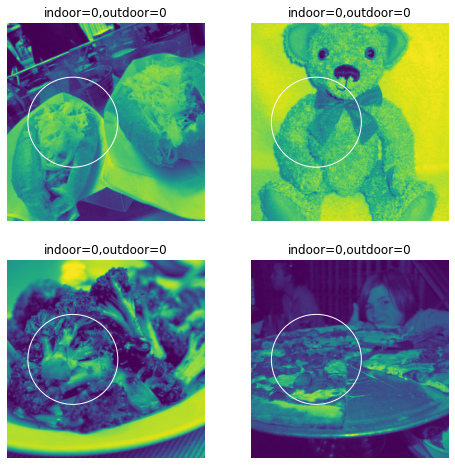

In [81]:
# plot examples - "neither"

ims2use = np.where((indoor_outdoor[:,0]==0) & (indoor_outdoor[:,1]==0) & \
                   np.isin(np.arange(10000), ims2load))[0]
images2plot = np.random.choice(ims2use,4);

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(8,8));

for ii, im in enumerate(images2plot):
    ax = plt.subplot(2,2,ii+1);
    plt.imshow(image_data[im,0,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('indoor=%d,outdoor=%d'%(indoor_outdoor[im,0], indoor_outdoor[im,1]))
    print('\nimage %d has:'%ii)
    print([cat_names[cc] for cc in range(len(cat_names)) if cat_labels[im,cc]==1])
    print([stuff_cat_names[cc] for cc in range(len(stuff_cat_names)) if stuff_cat_labels[im,cc]==1])

['sandwich' 'broccoli' 'dining table']
['fence' 'floor-other' 'food-other' 'napkin' 'other']


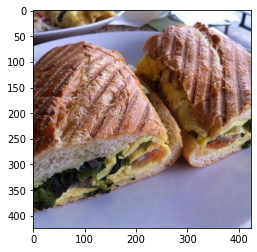

In [83]:
import PIL

fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_binary.csv'%subject)
coco_df = pd.read_csv(fn2load, index_col = 0)
fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_stuff_binary.csv'%subject)
coco_stuff_df = pd.read_csv(fn2load, index_col = 0)

conflict = np.sum(np.array(indoor_outdoor_df)==1, axis=1)==2

image_ind = np.random.choice(np.where(conflict)[0], 1)[0]
subject_df = nsd_utils.get_subj_df(subject=1)
cocoid = subject_df['cocoId'].iloc[image_ind]

# loading the image from two different places to make sure it is the same one   
cocoid = np.array(subject_df['cocoId'])[image_ind]
cocoim = '/lab_data/tarrlab/common/datasets/NSD_images/images/%d.jpg'%cocoid
im = PIL.Image.open(cocoim)

plt.figure();
plt.imshow(im)

binary_cat_in_image = np.array(coco_df.loc[image_ind])[12:92]
cat_in_image = np.array(cat_names)[binary_cat_in_image==1]
print(cat_in_image)

binary_stuff_cat_in_image = np.array(coco_stuff_df.loc[image_ind])[16:108]
stuff_cat_in_image = np.array(stuff_cat_names)[binary_stuff_cat_in_image==1]
print(stuff_cat_in_image)


['person' 'cup' 'fork' 'pizza']
['food-other' 'table' 'vegetable' 'wall-other' 'other']


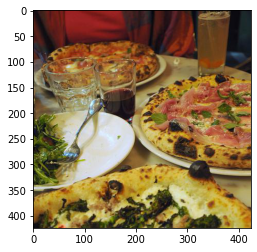

In [84]:
fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_binary.csv'%subject)
coco_df = pd.read_csv(fn2load, index_col = 0)
fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_stuff_binary.csv'%subject)
coco_stuff_df = pd.read_csv(fn2load, index_col = 0)

ambiguous = np.sum(np.array(indoor_outdoor_df)==1, axis=1)==0

image_ind = np.random.choice(np.where(ambiguous)[0], 1)[0]
subject_df = nsd_utils.get_subj_df(subject=1)
cocoid = subject_df['cocoId'].iloc[image_ind]

# loading the image from two different places to make sure it is the same one   
cocoid = np.array(subject_df['cocoId'])[image_ind]
cocoim = '/lab_data/tarrlab/common/datasets/NSD_images/images/%d.jpg'%cocoid
im = PIL.Image.open(cocoim)

plt.figure();
plt.imshow(im)

binary_cat_in_image = np.array(coco_df.loc[image_ind])[12:92]
cat_in_image = np.array(cat_names)[binary_cat_in_image==1]
print(cat_in_image)

binary_stuff_cat_in_image = np.array(coco_stuff_df.loc[image_ind])[16:108]
stuff_cat_in_image = np.array(stuff_cat_names)[binary_stuff_cat_in_image==1]
print(stuff_cat_in_image)


['person' 'microwave' 'refrigerator']
['cabinet' 'counter' 'floor-wood' 'textile-other' 'wall-concrete'
 'wall-tile' 'other']


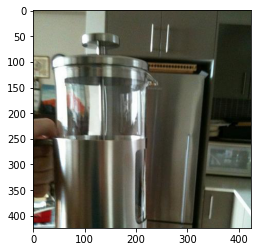

In [85]:
fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_binary.csv'%subject)
coco_df = pd.read_csv(fn2load, index_col = 0)
fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_stuff_binary.csv'%subject)
coco_stuff_df = pd.read_csv(fn2load, index_col = 0)

indoor = np.array(indoor_outdoor_df['has_indoor'])==1

image_ind = np.random.choice(np.where(indoor)[0], 1)[0]
subject_df = nsd_utils.get_subj_df(subject=1)
cocoid = subject_df['cocoId'].iloc[image_ind]

# loading the image from two different places to make sure it is the same one   
cocoid = np.array(subject_df['cocoId'])[image_ind]
cocoim = '/lab_data/tarrlab/common/datasets/NSD_images/images/%d.jpg'%cocoid
im = PIL.Image.open(cocoim)

plt.figure();
plt.imshow(im)

binary_cat_in_image = np.array(coco_df.loc[image_ind])[12:92]
cat_in_image = np.array(cat_names)[binary_cat_in_image==1]
print(cat_in_image)

binary_stuff_cat_in_image = np.array(coco_stuff_df.loc[image_ind])[16:108]
stuff_cat_in_image = np.array(stuff_cat_names)[binary_stuff_cat_in_image==1]
print(stuff_cat_in_image)


['person' 'train']
['building-other' 'dirt' 'fence' 'grass' 'ground-other' 'house' 'metal'
 'pavement' 'railroad' 'roof' 'stone' 'tree' 'other']


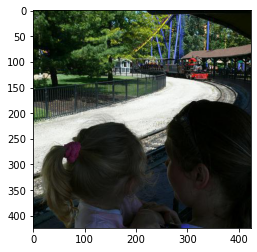

In [86]:
fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_binary.csv'%subject)
coco_df = pd.read_csv(fn2load, index_col = 0)
fn2load = os.path.join(default_paths.stim_labels_root, 'S%d_cocolabs_stuff_binary.csv'%subject)
coco_stuff_df = pd.read_csv(fn2load, index_col = 0)

outdoor = np.array(indoor_outdoor_df['has_outdoor'])==1

image_ind = np.random.choice(np.where(outdoor)[0], 1)[0]
subject_df = nsd_utils.get_subj_df(subject=1)
cocoid = subject_df['cocoId'].iloc[image_ind]

# loading the image from two different places to make sure it is the same one   
cocoid = np.array(subject_df['cocoId'])[image_ind]
cocoim = '/lab_data/tarrlab/common/datasets/NSD_images/images/%d.jpg'%cocoid
im = PIL.Image.open(cocoim)

plt.figure();
plt.imshow(im)

binary_cat_in_image = np.array(coco_df.loc[image_ind])[12:92]
cat_in_image = np.array(cat_names)[binary_cat_in_image==1]
print(cat_in_image)

binary_stuff_cat_in_image = np.array(coco_stuff_df.loc[image_ind])[16:108]
stuff_cat_in_image = np.array(stuff_cat_names)[binary_stuff_cat_in_image==1]
print(stuff_cat_in_image)
